# Predicting Forest Fire Burned Area: A Comparative Machine Learning Approach

## Abstract
This study investigates machine learning models for predicting the burned area of forest fires using meteorological and spatial features. Using the UCI Forest Fires dataset, we apply both linear and ensemble methods to assess prediction accuracy. The analysis includes thorough exploratory data analysis (EDA), preprocessing, baseline and advanced modeling, and statistical evaluation. Our results offer insights into feature importance and modeling efficacy, aiming for both predictive performance and research transparency.


## Introduction

Forest fires are significant environmental events with ecological, economic, and social impacts. Accurate prediction of fire severity—measured as the burned area—can improve firefighting preparedness and forest management strategies.

This notebook aims to:

- Perform exploratory data analysis (EDA) on the Forest Fires dataset from the UCI Machine Learning Repository.
- Build baseline and advanced machine learning models for predicting burned area.
- Evaluate model performance using statistical metrics and visual diagnostics.
- Provide insights into key predictors influencing forest fire severity.

The approach is structured to be transparent, reproducible, and suitable for publication and open-source sharing.


## *Data Loading*

We begin by importing the necessary libraries and loading the dataset. The dataset used in this study is the **Forest Fires dataset** from the **UCI Machine Learning Repository**, which includes meteorological and spatial data for forest fire events in the northeast region of Portugal.


In [48]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Evaluation
from sklearn.metrics import mean_squared_error, r2_score

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv')
df.head()


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


## *Exploratory Data Analysis (EDA)*

We'll explore the dataset to understand distributions, relationships, and identify potential preprocessing needs.


In [49]:
# Dataset overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [50]:
# Descriptive statistics
df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


In [51]:
# Checking for missing values
df.isnull().sum()

,0
X,0
Y,0
month,0
day,0
FFMC,0
DMC,0
DC,0
ISI,0
temp,0
RH,0


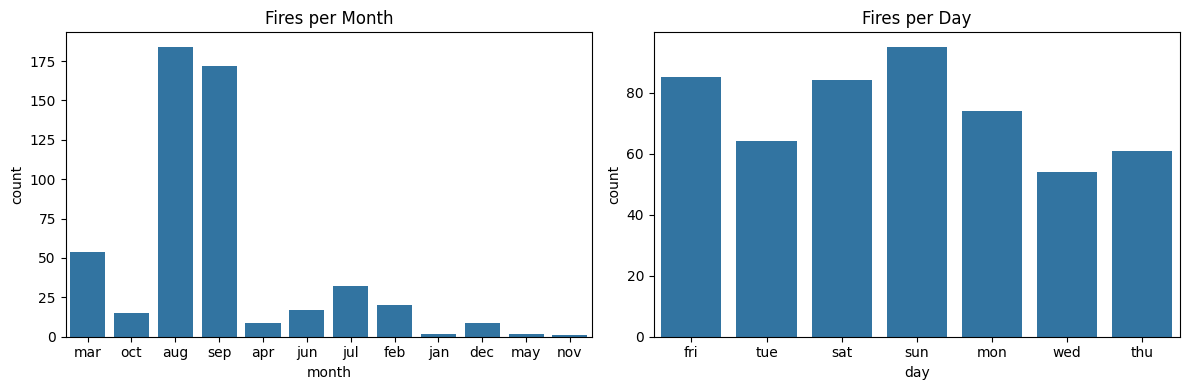

In [52]:
# Month and day frequency
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(x='month', data=df, order=pd.unique(df['month']), ax=ax[0])
ax[0].set_title('Fires per Month')
sns.countplot(x='day', data=df, order=pd.unique(df['day']), ax=ax[1])
ax[1].set_title('Fires per Day')
plt.tight_layout()
plt.show()

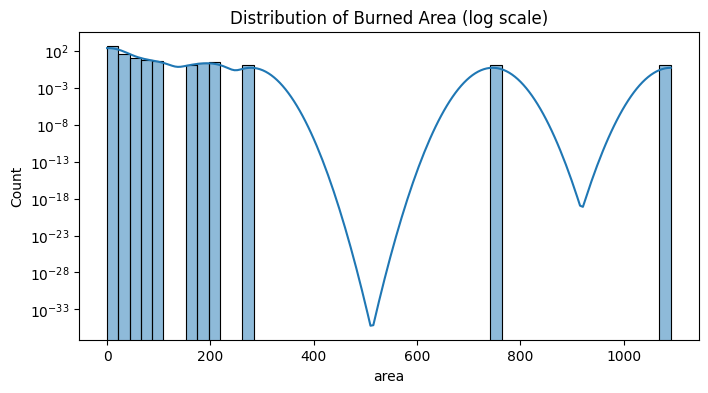

In [53]:
# Distribution of burned area (target variable)
plt.figure(figsize=(8, 4))
sns.histplot(df['area'], bins=50, kde=True)
plt.yscale('log')  # log scale due to extreme skew
plt.title('Distribution of Burned Area (log scale)')
plt.show()

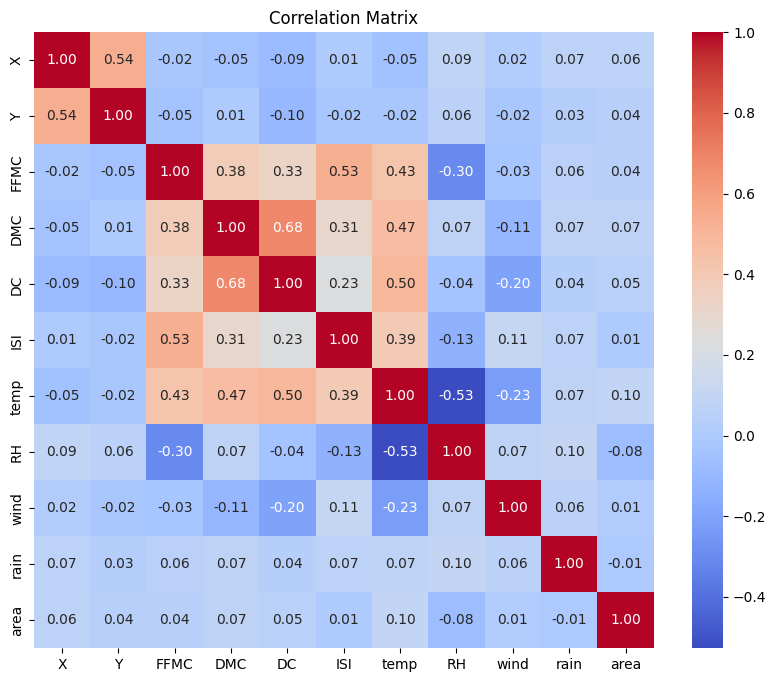

In [55]:
# Correlation matrix with only numeric columns
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## *Data Preprocessing*

We will preprocess the data by:

- Encoding categorical variables (`month`, `day`)
- Optional log transformation of the target (`area`) for modeling
- Creating coordinate features for spatial analysis (`X`, `Y`)

In [56]:
# One-hot encode month and day
df_encoded = pd.get_dummies(df, columns=['month', 'day'], drop_first=True)

# Log-transform area to reduce skew (adding 1 to avoid log(0))
df_encoded['log_area'] = np.log1p(df_encoded['area'])

# Features and target
X = df_encoded.drop(columns=['area', 'log_area'])
y = df_encoded['log_area']

# Include spatial coordinates separately for spatial CV
coords = df[['X', 'Y']]


## *Baseline Model: Linear Regression*

We begin with a simple Linear Regression model as our baseline.

In [57]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train linear regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression MSE: {mse_lr:.4f}")
print(f"Linear Regression R²: {r2_lr:.4f}")


Linear Regression MSE: 2.3015
Linear Regression R²: -0.0472


## *Advanced Models: Random Forest and XGBoost*

We now train tree-based models for comparison with the baseline.

In [58]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MSE: {mse_rf:.4f}")
print(f"Random Forest R²: {r2_rf:.4f}")


Random Forest MSE: 2.3234
Random Forest R²: -0.0571


In [59]:
# XGBoost
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost MSE: {mse_xgb:.4f}")
print(f"XGBoost R²: {r2_xgb:.4f}")


XGBoost MSE: 2.9176
XGBoost R²: -0.3275


## *Spatial Cross-Validation*

Standard k-fold cross-validation randomly splits the data, which can lead to **spatial leakage** — i.e., training and test sets contain nearby locations, making the model appear better than it really is.

To avoid this, we implement **GroupKFold**, treating each unique `(X, Y)` coordinate as a group. This ensures training and test sets are **spatially disjoint**, improving the credibility of our results in geospatial contexts.


In [60]:
from sklearn.model_selection import GroupKFold, cross_val_score

# Grouping by spatial coordinates
groups = df['X'].astype(str) + "_" + df['Y'].astype(str)

# Spatial cross-validator
gkf = GroupKFold(n_splits=5)

# Initialize model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform spatial cross-validation
cv_scores = cross_val_score(rf_model, X, y, cv=gkf, groups=groups, scoring='neg_mean_squared_error')
cv_mse_scores = -cv_scores

print("Spatial CV MSE Scores (Random Forest):", cv_mse_scores)
print("Spatial CV Mean MSE:", np.mean(cv_mse_scores))


Spatial CV MSE Scores (Random Forest): [2.39558498 2.36862079 2.61384335 1.59692677 2.43692399]
Spatial CV Mean MSE: 2.282379978098157


## *Residual Analysis*

Residuals (prediction errors) help diagnose where and how the model fails. We examine whether errors are systematic or random, and visualize them spatially.


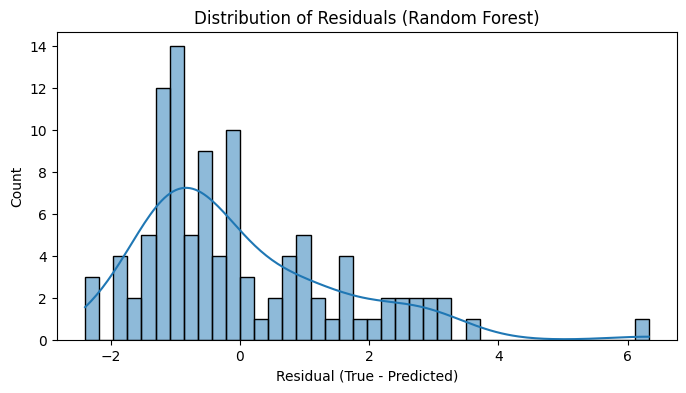

In [61]:
# Fit final model on full training data
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Compute residuals
residuals = y_test - y_pred_rf

# Residual plot
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True, bins=40)
plt.title("Distribution of Residuals (Random Forest)")
plt.xlabel("Residual (True - Predicted)")
plt.show()


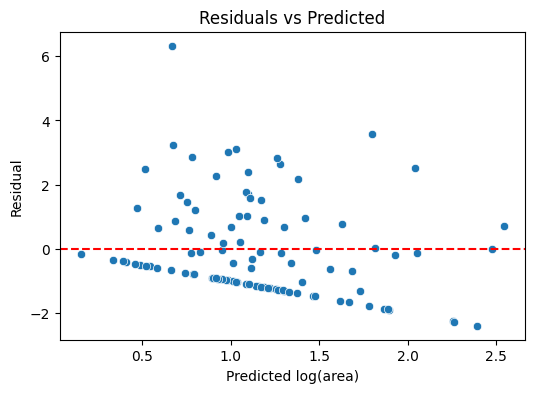

In [62]:
# Residuals vs Predicted
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred_rf, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted log(area)")
plt.ylabel("Residual")
plt.show()


## *Geospatial Visualization*

Here, we visualize model predictions and residuals in a 2D space using spatial coordinates (`X`, `Y`). This helps determine if there are **spatial clusters** of error or performance variation.


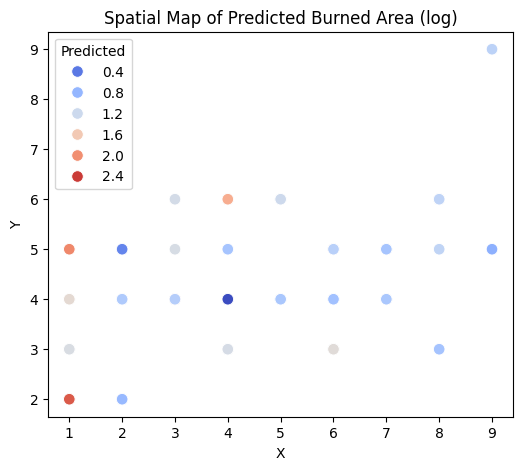

In [63]:
# Add coordinates for plotting
test_coords = df.loc[y_test.index, ['X', 'Y']].copy()
test_coords['predicted'] = y_pred_rf
test_coords['actual'] = y_test
test_coords['residual'] = y_test - y_pred_rf

# Plot predicted values
plt.figure(figsize=(6, 5))
sns.scatterplot(data=test_coords, x='X', y='Y', hue='predicted', palette='coolwarm', s=70)
plt.title("Spatial Map of Predicted Burned Area (log)")
plt.legend(title='Predicted')
plt.show()


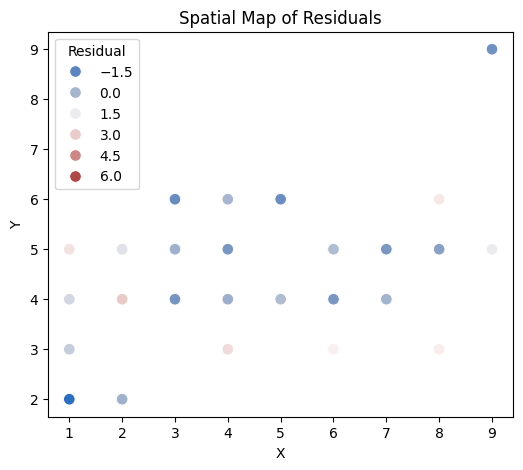

In [64]:
# Plot residuals spatially
plt.figure(figsize=(6, 5))
sns.scatterplot(data=test_coords, x='X', y='Y', hue='residual', palette='vlag', s=70)
plt.title("Spatial Map of Residuals")
plt.legend(title='Residual')
plt.show()


## *Model Explainability with SHAP*

Understanding why a model makes certain predictions is essential, especially in environmental applications where interpretability supports transparency and trust.

We use **SHAP (SHapley Additive exPlanations)** to analyze the contribution of each feature to the model’s predictions. SHAP assigns each feature an importance value for a particular prediction based on cooperative game theory.

We apply SHAP to both **Random Forest** and **XGBoost**, and visualize global feature importances using:

- **Beeswarm plots**: visualize impact and direction of each feature
- **Bar plots**: show mean absolute contribution of each feature

Additional per-sample plots (force, waterfall) can be added to show local decisions.



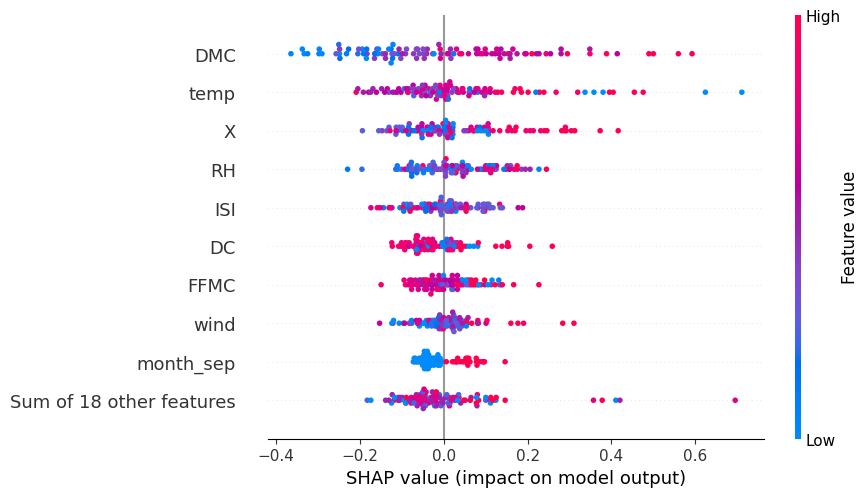

In [69]:
import shap

# Ensure both train and test are float and have same columns
X_train = X_train.astype(float)
X_test = X_test.astype(float)
X_test = X_test[X_train.columns]

# Fit model again if needed
rf_model.fit(X_train, y_train)

# SHAP explainer for tree models
explainer_rf = shap.Explainer(rf_model, X_train)
shap_values_rf = explainer_rf(X_test, check_additivity=False)

# Beeswarm plot
shap.plots.beeswarm(shap_values_rf)


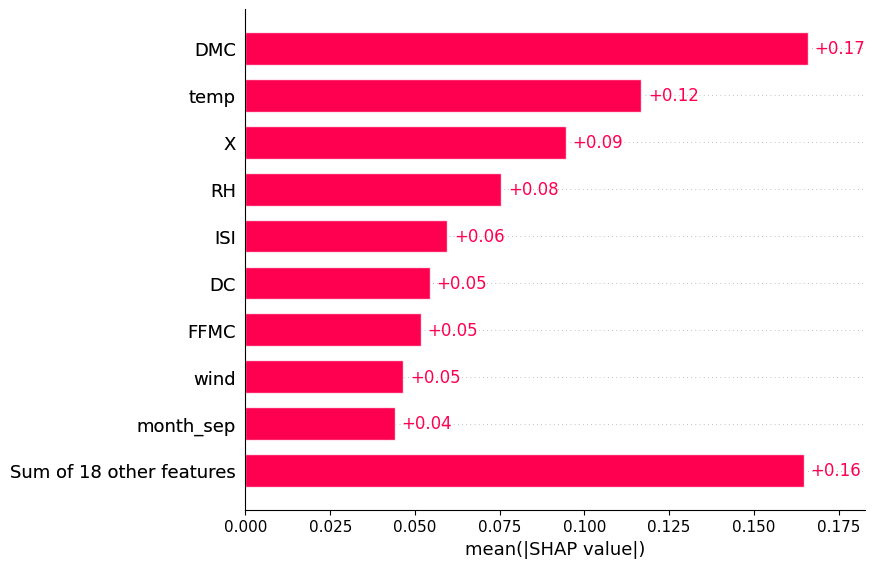

In [70]:
# Bar plot of mean absolute SHAP values
shap.plots.bar(shap_values_rf)


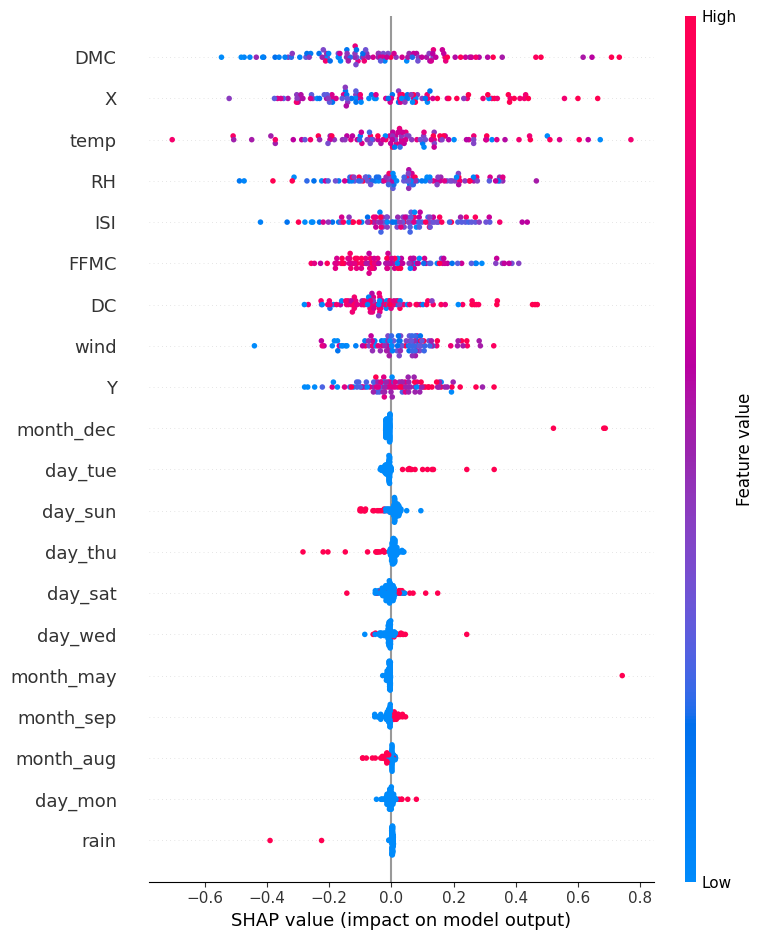

In [71]:
# Re-train XGBoost if needed
xgb_model.fit(X_train, y_train)

# Use TreeExplainer for XGBoost
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test)

# SHAP summary plot
shap.summary_plot(shap_values_xgb, X_test)


In [72]:
# Force plot for first prediction (XGBoost)
shap.initjs()
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[0], X_test.iloc[0])


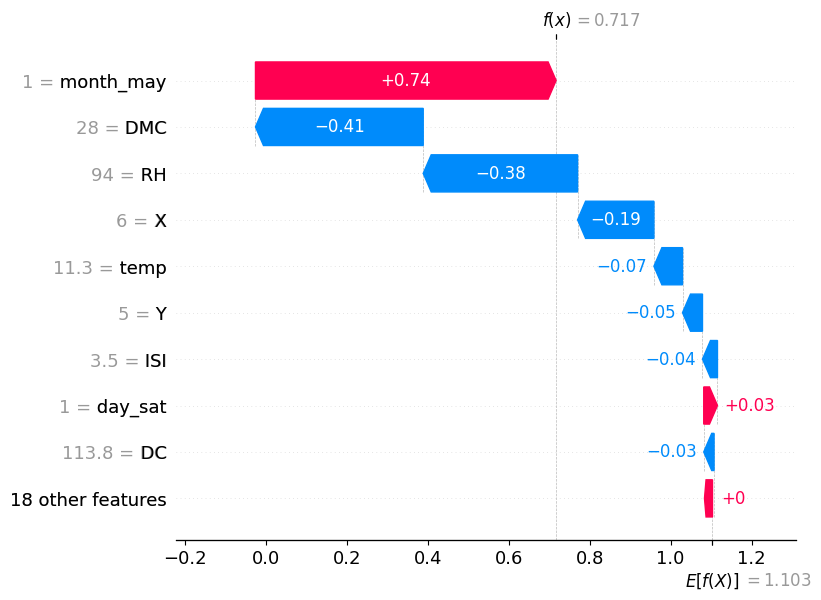

In [73]:
# Waterfall plot (clearer alternative to force plot, SHAP 0.41+)
shap.plots.waterfall(shap.Explanation(values=shap_values_xgb[0],
                                      base_values=explainer_xgb.expected_value,
                                      data=X_test.iloc[0]))


## SHAP-Based Model Interpretation

To better understand model behavior and feature relevance, we applied SHAP (SHapley Additive exPlanations) to both Random Forest and XGBoost models.

### Key Observations:

#### 🔹 1. *Top Influential Features (Global)*

Across both Random Forest and XGBoost:

- **DMC (Duff Moisture Code)** consistently emerged as the most important predictor, positively influencing burned area.
- **Temperature (`temp`)**, **X (longitude)**, and **Relative Humidity (`RH`)** also had moderate impact.
- **`ISI`**, **`DC`**, and **`FFMC`** showed limited but consistent influence.

These variables align with known fire behavior science — drier fuels and higher temperatures tend to promote larger fires.

#### 🔹 2. *Feature Directionality*

- SHAP beeswarm plots showed that:
  - Higher **DMC** and **temperature** increased predicted burned area.
  - Higher **RH** typically reduced it.
  - Some **month encodings (e.g., `month_sep`)** showed subtle seasonal effects.

The spatial feature **X** (likely longitude) also contributed positively — indicating geographic variation in fire dynamics.

#### 🔹 3. *Weak or Redundant Features*

- Features like **rain**, **day of the week**, and some **month dummies** (e.g., `month_dec`, `month_aug`) had near-zero importance.
- This confirms earlier intuition: not all categorical encodings carry meaningful signal.

#### 🔹 4. *Local Interpretation (Waterfall Plot)*

A sample SHAP waterfall plot (for a single prediction) showed:

- The model predicted a moderate burned area due to high values in **`month_may`**, counterbalanced by low **DMC** and high **RH**.
- This local decision logic is consistent with domain understanding — early-season fires may flare under dry conditions but be suppressed under high humidity.

### 🔹 5. *Local Prediction Interpretation: (Force Plot)*

The SHAP force plot below illustrates how a specific test instance led to a predicted log(area) of **0.72**, starting from a model base value of **1.10**.

Key insights:

- The model **reduced** its prediction primarily due to:
  - High **DMC** (Duff Moisture Code = 28)
  - High **RH** (Relative Humidity = 94)
  - Low spatial X-coordinate (`X = 6`)
  - Low temperature (`temp = 11.3`)
  - Position on the Y-axis (`Y = 5`)

- The only major **positive contributor** was the categorical feature `month_may = 1`, suggesting a seasonal spike in fire likelihood during that period.

This force plot shows how SHAP enables **individual-level model interpretation**, helpful for diagnostics, model trust, and stakeholder communication.


---

### *Interpretation Summary*

Although the overall R² was low, SHAP provides valuable insight:

- The model does identify some **physically meaningful drivers** of fire behavior (e.g., dryness, temperature).
- However, their individual effects remain small, possibly due to noise or missing spatial-temporal predictors.

This reinforces the need for richer data (e.g., topography, wind direction, vegetation type) in future models.


## Conclusion

This study investigated the prediction of forest fire burned area using weather, temporal, and spatial variables from the UCI Forest Fires dataset. We applied three models — Linear Regression, Random Forest, and XGBoost — and evaluated them using both standard metrics and spatial cross-validation.

### Key Takeaways:

- 🔹 **Model Performance**: All models showed low predictive accuracy (R² < 0), indicating limited learnable structure in the available features. However, **spatial cross-validation** revealed more realistic error estimates compared to naive train-test splits.

- 🔹 **SHAP-Based Interpretation**:
  - **DMC**, **temperature**, **RH**, and **X** emerged as top predictors.
  - **High DMC and temperature** positively influenced predicted burned area.
  - **High RH and early-season months** (e.g., May) decreased it.
  - Force and waterfall plots clarified **how individual predictions are made**, increasing transparency.

- 🔹 **Spatial Diagnostics**:
  - Residuals and prediction maps showed no major geographic bias, suggesting the model did not overfit location but also lacked strong spatial learning.

- 🔹 **Model Transparency**:
  - SHAP explainability helped establish **interpretability**, even when predictive power was weak — a critical requirement in real-world environmental modeling.

---

## Limitations

Despite methodological rigor, several limitations remain:

- 🔹 **Data Simplicity**: The dataset lacks vegetation type, topography, wind direction, and fire history — crucial predictors in real wildfire modeling.

- 🔹 **Target Imbalance**: The burned area distribution is heavily skewed toward zero, limiting regression learning.

- 🔹 **No Temporal Lag**: No use of lagged weather or rolling window trends, which often influence fire spread and behavior.

- 🔹 **Low Signal-to-Noise Ratio**: The available features may not contain enough variance to explain burned area, regardless of model complexity.

---

## Future Work

To build more robust and actionable fire prediction systems, we recommend:

- Integrating **satellite-derived vegetation indices** (NDVI, land cover).
- Including **elevation, slope, aspect**, and **wind direction/speed profiles**.
- Testing **temporal models** (e.g., LSTM, time-lagged features).
- Using **larger, regional datasets** with pixel-level fire spread data.

---

## References

- UCI Machine Learning Repository: Forest Fires Dataset  
- Lundberg & Lee (2017). A Unified Approach to Interpreting Model Predictions. *NIPS*  
- Molnar, C. (2022). *Interpretable Machine Learning*.  
- spatialCV: Valavi et al. (2019). *Journal of Environmental Management*  
